# β-VAE from Scratch (PyTorch)

Run each cell sequentially. This notebook trains a β-VAE on MNIST and visualizes reconstructions.

In [2]:
pip install streamlit torch torchvision matplotlib

  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached numpy-2.3.5-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pandas-2.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached pillow-12.0.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached gitpython-3.1.45-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.me

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [4]:

class Encoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.mu = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        return self.mu(h), self.logvar(h)


class Decoder(nn.Module):
    def __init__(self, latent_dim=10, output_dim=784):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc_out = nn.Linear(256, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc_out(h))


In [5]:

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


In [6]:

def beta_vae_loss(x, x_hat, mu, logvar, beta=4):
    recon_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss


In [7]:

class BetaVAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=10):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar


In [8]:

transform = transforms.ToTensor()
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)


100.0%
100.0%
100.0%
100.0%


In [9]:

model = BetaVAE(latent_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
beta = 4

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, _ in train_loader:
        x = x.view(x.size(0), -1).to(device)
        x_hat, mu, logvar = model(x)
        loss = beta_vae_loss(x, x_hat, mu, logvar, beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 197.1340
Epoch 2, Loss: 163.8544
Epoch 3, Loss: 158.6219
Epoch 4, Loss: 156.1481
Epoch 5, Loss: 154.7595
Epoch 6, Loss: 153.8903
Epoch 7, Loss: 153.1284
Epoch 8, Loss: 152.6076
Epoch 9, Loss: 152.0479
Epoch 10, Loss: 151.6373


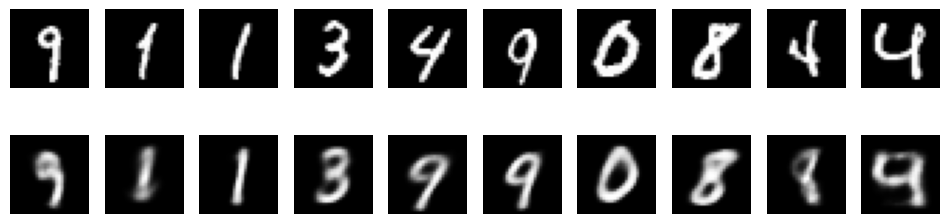

In [10]:

model.eval()
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x = x.view(x.size(0), -1).to(device)
    x_hat, _, _ = model(x)

fig, axes = plt.subplots(2, 10, figsize=(12, 3))
for i in range(10):
    axes[0, i].imshow(x[i].view(28, 28).cpu(), cmap="gray")
    axes[1, i].imshow(x_hat[i].view(28, 28).cpu(), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].axis("off")

plt.show()
